# Example Predictor: Linear Rollout Predictor

This example contains basic functionality for training and evaluating a linear predictor that rolls out predictions day-by-day.

First, a training data set is created from historical case and npi data.

Second, a linear model is trained to predict future cases from prior case data along with prior and future npi data.
The model is an off-the-shelf sklearn Lasso model, that uses a positive weight constraint to enforce the assumption that increased npis has a negative correlation with future cases.

Third, a sample evaluation set is created, and the predictor is applied to this evaluation set to produce prediction results in the correct format.

## Training

In [1]:
import pickle
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

In [2]:
# Helpful function to compute mae
def mae(pred, true):
    return np.mean(np.abs(pred - true))

### Copy the data locally

In [3]:
# Main source for the training data
DATA_URL = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
# Local file
DATA_FILE = 'data/OxCGRT_latest.csv'

In [4]:
import os
import urllib.request
if not os.path.exists('data'):
    os.mkdir('data')
urllib.request.urlretrieve(DATA_URL, DATA_FILE)

('data/OxCGRT_latest.csv', <http.client.HTTPMessage at 0x7f820cdafb10>)

In [5]:
# Load historical data from local file
df = pd.read_csv(DATA_FILE, 
                 parse_dates=['Date'],
                 encoding="ISO-8859-1",
                 dtype={"RegionName": str,
                        "RegionCode": str},
                 error_bad_lines=False)

In [6]:
df.columns

Index(['CountryName', 'CountryCode', 'RegionName', 'RegionCode',
       'Jurisdiction', 'Date', 'C1_School closing', 'C1_Flag',
       'C2_Workplace closing', 'C2_Flag', 'C3_Cancel public events', 'C3_Flag',
       'C4_Restrictions on gatherings', 'C4_Flag', 'C5_Close public transport',
       'C5_Flag', 'C6_Stay at home requirements', 'C6_Flag',
       'C7_Restrictions on internal movement', 'C7_Flag',
       'C8_International travel controls', 'E1_Income support', 'E1_Flag',
       'E2_Debt/contract relief', 'E3_Fiscal measures',
       'E4_International support', 'H1_Public information campaigns',
       'H1_Flag', 'H2_Testing policy', 'H3_Contact tracing',
       'H4_Emergency investment in healthcare', 'H5_Investment in vaccines',
       'H6_Facial Coverings', 'H6_Flag', 'H7_Vaccination policy', 'H7_Flag',
       'M1_Wildcard', 'ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex',
       'StringencyIndexForDisplay', 'StringencyLegacyIndex',
       'StringencyLegacyIndexForDispla

In [7]:
# # For testing, restrict training data to that before a hypothetical predictor submission date
# HYPOTHETICAL_SUBMISSION_DATE = np.datetime64("2020-07-31")
# df = df[df.Date <= HYPOTHETICAL_SUBMISSION_DATE]

In [8]:
# Add RegionID column that combines CountryName and RegionName for easier manipulation of data
df['GeoID'] = df['CountryName'] + '__' + df['RegionName'].astype(str)

In [9]:
# Add new cases column
df['NewCases'] = df.groupby('GeoID').ConfirmedCases.diff().fillna(0)

In [10]:
# Keep only columns of interest
id_cols = ['CountryName',
           'RegionName',
           'GeoID',
           'Date']
cases_col = ['NewCases']
npi_cols = ['C1_School closing',
            'C2_Workplace closing',
            'C3_Cancel public events',
            'C4_Restrictions on gatherings',
            'C5_Close public transport',
            'C6_Stay at home requirements',
            'C7_Restrictions on internal movement',
            'C8_International travel controls',
            'H1_Public information campaigns',
            'H2_Testing policy',
            'H3_Contact tracing',
            'H6_Facial Coverings']
df = df[id_cols + cases_col + npi_cols]

In [11]:
# Fill any missing case values by interpolation and setting NaNs to 0
df.update(df.groupby('GeoID').NewCases.apply(
    lambda group: group.interpolate()).fillna(0))

In [12]:
# Fill any missing NPIs by assuming they are the same as previous day
for npi_col in npi_cols:
    df.update(df.groupby('GeoID')[npi_col].ffill().fillna(0))

In [13]:
temp = pd.read_csv('temperature_data.csv')
temp['date_st'] = temp['Date'].apply(lambda e: e[5:])
temp['id'] = temp['GeoID'] + '_' + temp['date_st']
id_temp = dict(zip( temp['id'], temp['temp'] ))
id_holiday = dict(zip( temp['id'], temp['Holiday'] ))
tf = temp[['date_st','temp']]
tf = tf.groupby(['date_st']).mean().reset_index()
date_temp_avg = dict(zip( tf['date_st'], tf['temp'] ))
tf = temp[['date_st','Holiday']]
tf = tf.groupby(['date_st'])['Holiday'].agg(pd.Series.mode).reset_index()
date_holiday_avg = dict(zip( tf['date_st'], tf['Holiday'] ))
id_temp

{'Afghanistan__nan_01-01': 2.7268292682926836,
 'Afghanistan__nan_01-02': 2.9152032520325206,
 'Afghanistan__nan_01-03': 2.9459349593495934,
 'Afghanistan__nan_01-04': 2.7965853658536584,
 'Afghanistan__nan_01-05': 2.4123577235772347,
 'Afghanistan__nan_01-06': 2.3713008130081303,
 'Afghanistan__nan_01-07': 2.4534959349593493,
 'Afghanistan__nan_01-08': 2.2549593495934954,
 'Afghanistan__nan_01-09': 2.219268292682927,
 'Afghanistan__nan_01-10': 2.2303252032520327,
 'Afghanistan__nan_01-11': 2.563983739837398,
 'Afghanistan__nan_01-12': 2.7221951219512204,
 'Afghanistan__nan_01-13': 2.389186991869919,
 'Afghanistan__nan_01-14': 2.290813008130081,
 'Afghanistan__nan_01-15': 2.217967479674797,
 'Afghanistan__nan_01-16': 2.2412195121951224,
 'Afghanistan__nan_01-17': 2.432926829268292,
 'Afghanistan__nan_01-18': 2.406747967479675,
 'Afghanistan__nan_01-19': 2.1417886178861787,
 'Afghanistan__nan_01-20': 2.324878048780488,
 'Afghanistan__nan_01-21': 2.0624390243902444,
 'Afghanistan__nan_01

In [14]:
# Set number of past days to use to make predictions
nb_lookback_days = 30
date_ls = []
geoid_ls = []
country_ls = []
newcase_ls = []
# Create training data across all countries for predicting one day ahead
X_cols = cases_col + npi_cols
y_col = cases_col
X_samples = []
y_samples = []
geo_ids = df.GeoID.unique()
train_geo_ids = [e for e in geo_ids]
geoid_arr = np.zeros(len(train_geo_ids)+1)
for g in geo_ids:
    gdf = df[df.GeoID == g]
    all_case_data = np.array(gdf[cases_col])
    all_npi_data = np.array(gdf[npi_cols])

    # Create one sample for each day where we have enough data
    # Each sample consists of cases and npis for previous nb_lookback_days
    nb_total_days = len(gdf)
    for d in range(nb_lookback_days, nb_total_days - 1):
        X_cases = all_case_data[d-nb_lookback_days:d]

        # Take negative of npis to support positive
        # weight constraint in Lasso.
        X_npis = -all_npi_data[d - nb_lookback_days:d]
        
        date_ls += [ list(gdf['Date'])[d] ]
        geoid_ls += [ list(gdf['GeoID'])[d] ]
        country_ls += [ list(gdf['CountryName'])[d]  ] 
        newcase_ls += [ list(gdf['NewCases'])[d]  ] 
        
        date_st = str(date_ls[-1])[5:10] 
        id_ = geoid_ls[-1] + '_' + date_st

        temperature = date_temp_avg[date_st]
        holiday = date_holiday_avg[date_st]
        if id_ in id_temp:
            temperature = id_temp[id_]
            holiday = id_holiday[id_]            
        
        # Flatten all input data so it fits Lasso input format.
        geoid_arr = np.zeros(len(train_geo_ids)+1)
        geoid_arr[ train_geo_ids.index(g) ] = 1
        X_sample = np.concatenate([[temperature,holiday], X_cases.flatten(), #geoid_arr,
                                   X_npis.flatten()])
        y_sample = all_case_data[d]
        X_samples.append(X_sample)
        y_samples.append(y_sample)


X_samples = np.array(X_samples)
y_samples = np.array(y_samples).flatten()
y_samples = np.maximum(y_samples, 0) # Don't predict negative cases
with open('train_geo_ids.txt', 'w') as f:
    f.write('\n'.join(train_geo_ids))
    
print(X_samples.shape)

(90160, 392)


In [15]:
len(set(geoid_ls))

280

In [16]:
# Split data into train and test sets
X_train_all,  y_train_all = X_samples, y_samples
print(X_train_all.shape, y_train_all.shape)

(90160, 392) (90160,)


In [17]:
# geoid_ls = np.array(geoid_ls)

In [18]:
!pip install lightgbm

In [19]:
import random
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
seed_everything(42) 

In [20]:
!pip install optuna

In [21]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')

# import optuna.integration.lightgbm as lgb
# import lightgbm as lgb


# params = {
#     'boosting_type': 'gbdt',
#     'objective': 'regression',
#     'metric': 'rmse',
#     'subsample': 0.5,
#     'subsample_freq': 1,
#     'learning_rate': 0.03,
#     'num_leaves': 2 ** 5 - 1,#11
#     'min_data_in_leaf': 2 ** 6 - 1,#12
#     'feature_fraction': 0.5,
#     'max_bin': 100,
#     'n_estimators': 1000,#140,#140,#0,
#     'boost_from_average': False,
#     'verbose': -1,
# }




# for ii in range(len(train_geo_ids)):
#     g = train_geo_ids[ii]
#     MODEL_FILE = 'models/lgb_' + g + '.pkl'
#     if True:#not(os.path.exists(MODEL_FILE)):
#         tr_idx = [i for i in range(len(geoid_ls)) if geoid_ls[i]==g ]
#         tr_idx = np.array(tr_idx)
#         X_train, y_train = X_train_all[tr_idx,:], y_train_all[tr_idx]

#         dtrain = lgb.Dataset(X_train, label=y_train)
#         lgb_model_tune = lgb.train(params, dtrain, valid_sets=[dtrain], early_stopping_rounds=100,verbose_eval=100 )

#         with open(MODEL_FILE, 'wb') as model_file:
#             pickle.dump(lgb_model_tune, model_file)    

#         if (ii%10==0):
#             print('have done ', ii//10, ' models')

## Evaluation

Now that the predictor has been trained and saved, this section contains the functionality for evaluating it on sample evaluation data.

In [22]:
# Reload the module to get the latest changes
import predict
from importlib import reload
reload(predict)
from predict import predict_df

In [23]:
# %%time
preds_df = predict_df("2020-08-01", "2020-08-31", path_to_ips_file="data/2020-09-30_historical_ip.csv", verbose=True)


Predicting for Aruba__nan
2020-08-01: 7.114327212934471
2020-08-02: 7.45224540483501
2020-08-03: 13.310068462921103
2020-08-04: 18.79483774180352
2020-08-05: 21.535192928152743
2020-08-06: 19.786352427397812
2020-08-07: 21.02887041840427
2020-08-08: 23.289079634126754
2020-08-09: 28.361305541899288
2020-08-10: 32.605677480123134
2020-08-11: 28.515626920611528
2020-08-12: 28.713586792493484
2020-08-13: 28.849844701942065
2020-08-14: 28.005894458380613
2020-08-15: 27.41740473946046
2020-08-16: 27.9872962180511
2020-08-17: 26.643563709033057
2020-08-18: 25.14079257565699
2020-08-19: 24.955642621155693
2020-08-20: 24.99759210701792
2020-08-21: 23.567028127381082
2020-08-22: 23.21290086180062
2020-08-23: 25.854730137351748
2020-08-24: 26.442060985719706
2020-08-25: 26.81607918970298
2020-08-26: 27.951928805127086
2020-08-27: 27.4509237969649
2020-08-28: 26.359648878200545
2020-08-29: 25.47427810795594
2020-08-30: 25.76988151553722
2020-08-31: 26.260569291996593

Predicting for Afghanistan_

2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0.15782131793358675
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0.19079586684809205

Predicting for Belgium__nan
2020-08-01: 4408.61225018294
2020-08-02: 4411.161251270699
2020-08-03: 4150.671885316137
2020-08-04: 4398.102392675001
2020-08-05: 4486.547884554553
2020-08-06: 4325.338697184255
2020-08-07: 4395.646871646759
2020-08-08: 4285.384963895035
2020-08-09: 4466.103735319103
2020-08-10: 4251.294653601695
2020-08-11: 4203.178505395846
2020-08-12: 4286.286259435095
2020-08-13: 4267.476576889777
2020-08-14: 4196.914415233349
2020-08-15: 4181.96816898792
2020-08-16: 4309.384273564656
2020-08-17: 4349.44378730037
2020-08-18: 4292.96325386532
2020-08-19: 3713.241671411969
2020-08-20: 3412.9517116016423
2020-08-21: 3409.351816469781
2020-08-22: 3600.0126059459826
2020-08-23: 3542.4982783857845
2020-08-24: 4260.82275493129
2020-08-25: 3828.1941982354474
2020-08-26: 3111.312990058865
2020-08-27: 2748.6431393369653
2020-08-28: 2908.7425832518

2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 27.44718105819353

Predicting for Belize__nan
2020-08-01: 116.58417923282724
2020-08-02: 67.76113553293001
2020-08-03: 49.44240920382147
2020-08-04: 54.63641217328231
2020-08-05: 49.176902855527935
2020-08-06: 44.761461263012755
2020-08-07: 72.74971595233518
2020-08-08: 87.07626766871586
2020-08-09: 71.84118419211559
2020-08-10: 61.28621125546176
2020-08-11: 54.929109743051505
2020-08-12: 62.91426954763552
2020-08-13: 64.41100041215743
2020-08-14: 65.8234826072629
2020-08-15: 64.87152495115218
2020-08-16: 69.52400023035582
2020-08-17: 74.19860316519302
2020-08-18: 67.17811873324939
2020-08-19: 71.67292951739174
2020-08-20: 67.70303247119102
2020-08-21: 62.29710331572715
2020-08-22: 63.78543076933044
2020-08-23: 66.2059320415957
2020-08-24: 73.50014362626221
2020-08-25: 70.5435587157796
2020-08-26: 69.01634870468689
2020-08-27: 68.20330773810758
2020-08-28: 72.66659988401055
2020-08-29: 70.4599802563863
2020-08-30: 70.34981505756726


2020-08-17: 1317.8766009221895
2020-08-18: 1231.4677173845585
2020-08-19: 1148.0138889532561
2020-08-20: 1316.483719853962
2020-08-21: 1520.4132662823588
2020-08-22: 1251.3199501111164
2020-08-23: 1199.1992635443928
2020-08-24: 1098.6845862660982
2020-08-25: 1113.1558403542622
2020-08-26: 1336.048579196
2020-08-27: 1375.947376413223
2020-08-28: 1325.4528208066451
2020-08-29: 1107.3539715902714
2020-08-30: 1205.8404440440702
2020-08-31: 1303.9763473134822

Predicting for Brazil__Espirito Santo
2020-08-01: 0
2020-08-02: 191.7453588151702
2020-08-03: 504.4390777406489
2020-08-04: 246.50699098986482
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 138.37846314965302
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

P

2020-08-06: 674.5814281110759
2020-08-07: 451.9743009727596
2020-08-08: 407.4477131663734
2020-08-09: 503.31767887593327
2020-08-10: 660.785607573869
2020-08-11: 584.7788618623823
2020-08-12: 622.9041259691373
2020-08-13: 599.6876860551362
2020-08-14: 503.3426062939301
2020-08-15: 524.4234661943979
2020-08-16: 653.4645447214929
2020-08-17: 779.2671187254829
2020-08-18: 709.6396280773778
2020-08-19: 825.826346583364
2020-08-20: 822.1638214373146
2020-08-21: 611.6743915159296
2020-08-22: 551.2709570248718
2020-08-23: 609.7265265815505
2020-08-24: 708.2767470252937
2020-08-25: 647.8552220911474
2020-08-26: 725.6564829195131
2020-08-27: 814.5337389967438
2020-08-28: 662.9404530932098
2020-08-29: 561.3705679748119
2020-08-30: 629.7948308446566
2020-08-31: 715.2127544051157

Predicting for Brazil__Parana
2020-08-01: 0
2020-08-02: 587.7798052674386
2020-08-03: 1818.4517348851598
2020-08-04: 1483.5915466384945
2020-08-05: 1544.4047572149475
2020-08-06: 1353.5445133289302
2020-08-07: 323.966830

2020-08-25: 6060.312960030352
2020-08-26: 5457.965923852806
2020-08-27: 6147.092070743463
2020-08-28: 5932.20123439074
2020-08-29: 3463.349013192331
2020-08-30: 4651.450200561931
2020-08-31: 6704.598038417155

Predicting for Brazil__Tocantins
2020-08-01: 262.63310832731787
2020-08-02: 369.2214779721201
2020-08-03: 362.6528994360135
2020-08-04: 324.91777119973204
2020-08-05: 393.53836632415573
2020-08-06: 492.41780252029304
2020-08-07: 460.7390657887032
2020-08-08: 445.1912122555502
2020-08-09: 435.0974599450269
2020-08-10: 454.2654921313702
2020-08-11: 456.09079222149825
2020-08-12: 546.6299574097053
2020-08-13: 512.1586648888026
2020-08-14: 481.1652526249989
2020-08-15: 540.993531013954
2020-08-16: 503.2742541909728
2020-08-17: 507.6797266206
2020-08-18: 519.1135912210142
2020-08-19: 571.2627039866372
2020-08-20: 589.4283412092364
2020-08-21: 562.3143922977497
2020-08-22: 576.6701556624714
2020-08-23: 503.8180058415882
2020-08-24: 518.3595164615248
2020-08-25: 526.3242742860854
2020-0

2020-08-29: 4638.016960205349
2020-08-30: 4540.787307180272
2020-08-31: 4538.99001427003

Predicting for China__nan
2020-08-01: 0
2020-08-02: 143.29401599221902
2020-08-03: 188.52142260072867
2020-08-04: 382.97051268181764
2020-08-05: 456.40191019167867
2020-08-06: 452.650208992555
2020-08-07: 298.13419486656403
2020-08-08: 266.90073595605116
2020-08-09: 129.26719484042366
2020-08-10: 40.61241752246333
2020-08-11: 107.20721866066984
2020-08-12: 310.054851553558
2020-08-13: 491.4887430031746
2020-08-14: 614.1894427050919
2020-08-15: 737.0798335989107
2020-08-16: 632.8927953681342
2020-08-17: 498.33789247105904
2020-08-18: 414.1922485079666
2020-08-19: 485.5547537884374
2020-08-20: 706.9832335107147
2020-08-21: 762.2599041055131
2020-08-22: 1022.5872928333251
2020-08-23: 1511.9757481919917
2020-08-24: 1537.7781907763217
2020-08-25: 1416.0644582239552
2020-08-26: 1411.9836899741529
2020-08-27: 1387.7719843509842
2020-08-28: 1301.9715482063268
2020-08-29: 1197.5731085058778
2020-08-30: 110

2020-08-23: 1473.898450043724
2020-08-24: 936.3502574891824
2020-08-25: 893.3150100463877
2020-08-26: 895.0734753146672
2020-08-27: 91.80307204158399
2020-08-28: 1224.3114975599017
2020-08-29: 0
2020-08-30: 1550.7962089032053
2020-08-31: 821.5126442488856

Predicting for Cuba__nan
2020-08-01: 24.414150963151577
2020-08-02: 27.867324566757585
2020-08-03: 30.422980599571652
2020-08-04: 35.57307977449745
2020-08-05: 40.12220342380853
2020-08-06: 49.87100193486137
2020-08-07: 53.9194200550285
2020-08-08: 57.42053817577845
2020-08-09: 57.749901535712915
2020-08-10: 53.48383008621317
2020-08-11: 50.13659976170161
2020-08-12: 49.896188139321396
2020-08-13: 51.13670847979965
2020-08-14: 53.322106049086266
2020-08-15: 56.54947167174818
2020-08-16: 59.484982519189266
2020-08-17: 61.36151475806822
2020-08-18: 60.093827091000094
2020-08-19: 66.85816338496569
2020-08-20: 63.15958526259399
2020-08-21: 57.2638245246982
2020-08-22: 54.6321289255898
2020-08-23: 58.347948324617924
2020-08-24: 59.4085079

2020-08-28: 414.81568948231427
2020-08-29: 560.1690417258809
2020-08-30: 860.3476846911125
2020-08-31: 516.0477768084534

Predicting for Egypt__nan
2020-08-01: 188.55792296945032
2020-08-02: 97.66288691754153
2020-08-03: 93.09475368235132
2020-08-04: 85.18269579989871
2020-08-05: 60.44872696389176
2020-08-06: 77.28210982643849
2020-08-07: 77.70965735890373
2020-08-08: 88.95321157661496
2020-08-09: 104.23006277398726
2020-08-10: 124.82605641930087
2020-08-11: 110.04248391983951
2020-08-12: 124.75932364432876
2020-08-13: 144.20111107239273
2020-08-14: 151.69717423987845
2020-08-15: 153.66066282429983
2020-08-16: 149.70227831287906
2020-08-17: 148.08559117744136
2020-08-18: 144.57861717341495
2020-08-19: 137.8004613411565
2020-08-20: 141.26378678489323
2020-08-21: 150.07629796908435
2020-08-22: 123.44212087087392
2020-08-23: 120.01502032779842
2020-08-24: 101.05239273795212
2020-08-25: 68.01653566288034
2020-08-26: 49.27964767794375
2020-08-27: 29.131987853468317
2020-08-28: 0
2020-08-29:

2020-08-11: 9444.96863237286
2020-08-12: 8697.036123219996
2020-08-13: 8636.559722479591
2020-08-14: 9307.862654054798
2020-08-15: 9321.867247366055
2020-08-16: 9314.283858545074
2020-08-17: 9218.126541330928
2020-08-18: 9201.435033657355
2020-08-19: 9318.852215665289
2020-08-20: 8718.235802578525
2020-08-21: 8487.071236858934
2020-08-22: 9010.8053758842
2020-08-23: 8490.192511867739
2020-08-24: 8260.970639852943
2020-08-25: 8788.112446365574
2020-08-26: 7897.671102638963
2020-08-27: 6446.3230200522685
2020-08-28: 6990.287349589654
2020-08-29: 6699.996429037288
2020-08-30: 7352.577589302817
2020-08-31: 9285.8694041807

Predicting for United Kingdom__England
2020-08-01: 5234.452744611081
2020-08-02: 7292.983657597942
2020-08-03: 7451.600710740997
2020-08-04: 7345.092513441771
2020-08-05: 7292.237178200966
2020-08-06: 7187.111183935151
2020-08-07: 7433.886975993208
2020-08-08: 8108.5654681940905
2020-08-09: 8149.582979974658
2020-08-10: 7879.421759932838
2020-08-11: 7802.267837456466
202

2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Greenland__nan
2020-08-01: 0.03361176742101144
2020-08-02: 0.03361176742101144
2020-08-03: 0.03361176742101144
2020-08-04: 0.03361176742101144
2020-08-05: 0.03361176742101144
2020-08-06: 0.03361176742101144
2020-08-07: 0.03361176742101144
2020-08-08: 0.03361176742101144
2020-08-09: 0.03361176742101144
2020-08-10: 0.03361176742101144
2020-08-11: 0.03361176742101144
2020-08-12: 0.03361176742101144
2020-08-13: 0.03361176742101144
2020-08-14: 0.03361176742101144
2020-08-15: 0.03361176742101144
2020-08-16: 0.03361176742101144
2020-08-17: 0.03361176742101144
2020-08-18: 0.03361176742101144
2020-08-19: 0.03361176742101144
2020-08-20: 0.03361176742101144
2020-08-21: 0.0336117

2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Indonesia__nan
2020-08-01: 3470.5096788385977
2020-08-02: 3567.6702595042652
2020-08-03: 3908.4172163079475
2020-08-04: 4022.6313567970724
2020-08-05: 3796.659346941483
2020-08-06: 3234.714154322194
2020-08-07: 3377.407448062984
2020-08-08: 3758.6485008221416
2020-08-09: 3775.965148551309
2020-08-10: 3862.6742074590343
2020-08-11: 3891.2415006323768
2020-08-12: 3926.5831019141087
2020-08-13: 3785.3904902255126
2020-08-14: 3757.1315390725754
2020-08-15: 3732.786566758479
2020-08-16: 3848.6392893423667
2020-08-17: 3977.244494419174
2020-08-18: 3795.5498409755082
2020-08-19: 3672.2141879335622
2020-08-20: 3590.8962139289247
2020-

2020-08-08: 102.0580181832263
2020-08-09: 91.38828952329865
2020-08-10: 91.50914279151853
2020-08-11: 98.72369866468564
2020-08-12: 101.4335627743119
2020-08-13: 91.659763661752
2020-08-14: 91.8154520643316
2020-08-15: 100.28204457059077
2020-08-16: 97.85321090219504
2020-08-17: 107.49334338660907
2020-08-18: 105.66265189698974
2020-08-19: 96.3264828178652
2020-08-20: 96.2466779964162
2020-08-21: 89.9453349683573
2020-08-22: 93.84591678646972
2020-08-23: 99.86166914462002
2020-08-24: 94.15504031314856
2020-08-25: 98.23497359299446
2020-08-26: 95.63791158088522
2020-08-27: 97.0224491058804
2020-08-28: 108.55062057505184
2020-08-29: 104.40671054667503
2020-08-30: 99.45752480760082
2020-08-31: 99.37891193635615

Predicting for Jordan__nan
2020-08-01: 1664.1761339019768
2020-08-02: 1674.0630151979499
2020-08-03: 1765.893869492178
2020-08-04: 1841.4742310433026
2020-08-05: 1770.9817759927455
2020-08-06: 1761.2721882269832
2020-08-07: 1820.2699344319515
2020-08-08: 1829.9795221977138
2020-08

2020-08-04: 0.17575023230250397
2020-08-05: 0.18586114338096382
2020-08-06: 0.1653938684712256
2020-08-07: 0.23856878399517428
2020-08-08: 0.12636696254135704
2020-08-09: 0.17575023230250397
2020-08-10: 0.13207952040021545
2020-08-11: 0.19207217579334118
2020-08-12: 0.18265738860112984
2020-08-13: 0.20521380040109694
2020-08-14: 0.18586114338096382
2020-08-15: 0.11643337471923051
2020-08-16: 0.11643337471923051
2020-08-17: 0.17539466267519904
2020-08-18: 0.18265738860112984
2020-08-19: 0.20593021089216948
2020-08-20: 0.13866116186404143
2020-08-21: 0.20521380040109694
2020-08-22: 0.17575023230250397
2020-08-23: 0.13518480826809579
2020-08-24: 0.2104843449258121
2020-08-25: 0.13866116186404143
2020-08-26: 0.12904461351375945
2020-08-27: 0.2185235339671836
2020-08-28: 0.17575023230250397
2020-08-29: 0.09870983414282253
2020-08-30: 0.12181645136446664
2020-08-31: 0.23856878399517428

Predicting for Lebanon__nan
2020-08-01: 807.7763826916834
2020-08-02: 736.801766342432
2020-08-03: 845.078

2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Morocco__nan
2020-08-01: 1004.0554941582338
2020-08-02: 924.6025901866083
2020-08-03: 772.522835367585
2020-08-04: 697.9294182602605
2020-08-05: 585.7302095341729
2020-08-06: 361.5612487296018
2020-08-07: 164.80705949277242
2020-08-08: 283.6514287604138
2020-08-09: 369.7396570725936
2020-08-10: 254.36448500948035
2020-08-11: 93.00605898774599
2020-08-12: 0
2020-08-13: 0
2020-08-14: 2.4762454245156635
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 7.812666511677408
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Monaco__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020

2020-08-21: 127.87901520031168
2020-08-22: 133.99477216604998
2020-08-23: 135.72727490882465
2020-08-24: 135.7811967586347
2020-08-25: 133.97516801214363
2020-08-26: 134.50997492474661
2020-08-27: 128.06300459606123
2020-08-28: 123.85100490157511
2020-08-29: 130.90224030541825
2020-08-30: 137.26962652109273
2020-08-31: 139.04759696362296

Predicting for Mauritius__nan
2020-08-01: 1.9946237320806026
2020-08-02: 1.9946237320806026
2020-08-03: 2.067755634737502
2020-08-04: 2.067755634737502
2020-08-05: 2.067755634737502
2020-08-06: 2.067755634737502
2020-08-07: 2.067755634737502
2020-08-08: 1.9946237320806026
2020-08-09: 1.9946237320806026
2020-08-10: 2.067755634737502
2020-08-11: 2.067755634737502
2020-08-12: 2.067755634737502
2020-08-13: 2.067755634737502
2020-08-14: 2.067755634737502
2020-08-15: 1.9946237320806026
2020-08-16: 1.9946237320806026
2020-08-17: 2.067755634737502
2020-08-18: 2.067755634737502
2020-08-19: 2.067755634737502
2020-08-20: 2.067755634737502
2020-08-21: 2.067755634

2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Nepal__nan
2020-08-01: 903.2127496479624
2020-08-02: 916.3358457009223
2020-08-03: 935.3610095873323
2020-08-04: 1059.187641907657
2020-08-05: 1096.4482089852645
2020-08-06: 1122.0298152750493
2020-08-07: 1197.7384312616123
2020-08-08: 1185.9193549451184
2020-08-09: 1179.8849390942496
2020-08-10: 1122.263513630758
2020-08-11: 1081.0432617347888
2020-08-12: 1166.7374496212894
2020-08-13: 1056.8897911728307
2020-08-14: 1128.2384237148633
2020-08-15: 1104.062444218938
2020-08-16: 1076.8432383569136
2020-08-17: 1231.2942628709504
2020-08-18: 1266.6323862737167
2020-08-19: 1261.291246850489
2020-08-20: 1256.7372523012455
2020-08-21: 1265.9830847820642
2020-08-22: 1242.801609668387
2020-08-23: 1250.0063013734107
2020-08-24: 1307.7875296821387
2020-08-25: 1338.7011919533356
2020-08-26: 1241.9344847459329
2020-08-27: 1148.815419944317
2020-08-28: 1148.6963712030065
2020-08-29: 1095.2255185236713
2020-08-30: 1154.7083452037984
2020-08-31

2020-08-31: 0

Predicting for Paraguay__nan
2020-08-01: 461.6271378563453
2020-08-02: 546.7987210062611
2020-08-03: 568.9751746486218
2020-08-04: 564.1872472790284
2020-08-05: 566.865014821197
2020-08-06: 524.9096942113972
2020-08-07: 523.2900129601031
2020-08-08: 551.7472042770074
2020-08-09: 573.7610297912291
2020-08-10: 566.9221795399665
2020-08-11: 563.0716567163599
2020-08-12: 540.7223253007472
2020-08-13: 518.755148742767
2020-08-14: 516.3714141715112
2020-08-15: 518.2116601013169
2020-08-16: 557.668209369094
2020-08-17: 565.2313259856238
2020-08-18: 538.2091628603986
2020-08-19: 470.9708440252628
2020-08-20: 459.55888966355553
2020-08-21: 513.8489113374394
2020-08-22: 529.9133912875894
2020-08-23: 548.2402257684944
2020-08-24: 551.7014839866952
2020-08-25: 554.9559985761506
2020-08-26: 534.6093251328901
2020-08-27: 500.15480908754455
2020-08-28: 508.8588444816141
2020-08-29: 555.9775852892712
2020-08-30: 576.1411258415741
2020-08-31: 576.1267381319922

Predicting for Palestine__


Predicting for Senegal__nan
2020-08-01: 63.137274650867795
2020-08-02: 44.44050528675582
2020-08-03: 56.774695000125384
2020-08-04: 61.5802018458003
2020-08-05: 68.12135147314157
2020-08-06: 63.856038122614635
2020-08-07: 61.33096825327296
2020-08-08: 85.57645950108727
2020-08-09: 81.36812124936388
2020-08-10: 93.76356585587644
2020-08-11: 95.25987577371203
2020-08-12: 82.08921884651892
2020-08-13: 86.96790242912815
2020-08-14: 106.32517203285215
2020-08-15: 101.27497344452962
2020-08-16: 84.11470792691118
2020-08-17: 95.61005641153672
2020-08-18: 105.74475230313737
2020-08-19: 99.96226614980277
2020-08-20: 94.4351065994175
2020-08-21: 97.09000534518879
2020-08-22: 97.51813319156133
2020-08-23: 91.07420473877596
2020-08-24: 102.42682491425532
2020-08-25: 103.6366412381501
2020-08-26: 95.82168815905486
2020-08-27: 84.23515625393236
2020-08-28: 88.96406998951286
2020-08-29: 95.4556870070859
2020-08-30: 88.19973093177589
2020-08-31: 91.78905651231742

Predicting for Singapore__nan
2020-0

2020-08-03: 1219.169841482116
2020-08-04: 1258.3116282856624
2020-08-05: 1272.2175449259107
2020-08-06: 1283.706595721336
2020-08-07: 1332.5926603002126
2020-08-08: 1353.2604027503912
2020-08-09: 1346.3727541433025
2020-08-10: 1334.1683584985235
2020-08-11: 1310.1120969567344
2020-08-12: 1325.668124130961
2020-08-13: 1338.934823419564
2020-08-14: 1341.8376429452853
2020-08-15: 1354.0137607586219
2020-08-16: 1333.1066175860476
2020-08-17: 1325.8309935431826
2020-08-18: 1345.22996469194
2020-08-19: 1340.4770474799031
2020-08-20: 1321.8007063366733
2020-08-21: 1303.4597693298685
2020-08-22: 1314.3082413549814
2020-08-23: 1318.9636366353539
2020-08-24: 1291.5548823998313
2020-08-25: 1270.2763556590924
2020-08-26: 1253.6109322522173
2020-08-27: 1242.067835801598
2020-08-28: 1222.0927696768952
2020-08-29: 1186.9962408771391
2020-08-30: 1261.3903454696313
2020-08-31: 1348.8800780303982

Predicting for Sweden__nan
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 3808.346812198074
2020-08-

2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for Timor-Leste__nan
2020-08-01: 0.07210005003844909
2020-08-02: 0.07210005003844909
2020-08-03: 0.0876542161415276
2020-08-04: 0.0876542161415276
2020-08-05: 0.0876542161415276
2020-08-06: 0.0876542161415276
2020-08-07: 0.0876542161415276
2020-08-08: 0.07210005003844909
2020-08-09: 0.07210005003844909
2020-08-10: 0.0876542161415276
2020-08-11: 0.0876542161415276
2020-08-12: 0.0876542161415276
2020-08-13: 0.0876542161415276
2020-08-14: 0.0876542161415276
2020-08-15: 0.07210005003844909
2020-08-16: 0.07210005003844909
2020-08-17: 0.0876542161415276
2020-08-18: 0.0876542161415276
2020-08-19: 0.0876542161415276
2020-08-20: 0.0876542161415276
2020-08-21: 0.0876542161415276
2020-08-22: 0.07210005003844909
2020-08-23: 0.07210005003844909
2020-08-24: 0.0876542161415276
2020-08-25: 0.0876542161415276
2020-08-26: 0.0876542161415276
2020-08-27: 0.0876542161415276
2020-08-28: 0.0876542161415276
2020-08-29: 0.0721000

2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for United States__Alaska
2020-08-01: 106.99411808127064
2020-08-02: 173.64688490201468
2020-08-03: 170.08307106336676
2020-08-04: 156.84433424068874
2020-08-05: 150.19995545591146
2020-08-06: 146.32292759529375
2020-08-07: 179.40446393820187
2020-08-08: 205.55794273448288
2020-08-09: 194.59503631367596
2020-08-10: 193.11427060007074
2020-08-11: 198.87680742347055
2020-08-12: 203.9406879564796
2020-08-13: 197.35231391779686
2020-08-14: 200.58466974278616
2020-08-15: 212.7673754603093
2020-08-16: 210.38577403714723
2020-08-17: 211.2310190199277
2020-08-18: 213.88727349468692
2020-08-19: 219.94326115123104
2020-08-20: 

2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for United States__Florida
2020-08-01: 7316.890032916426
2020-08-02: 7245.1378294381775
2020-08-03: 8190.121914003047
2020-08-04: 7428.972681107445
2020-08-05: 8249.45694030862
2020-08-06: 7287.795230683109
2020-08-07: 7991.067717456085
2020-08-08: 8820.233968822136
2020-08-09: 8869.261960467647
2020-08-10: 9004.297915713367
2020-08-11: 8895.806294014963
2020-08-12: 8752.560733004577
2020-08-13: 8961.847243577198
2020-08-14: 9204.538321888253
2020-08-15: 9136.189615727832
2020-08-16: 8993.248717165381
2020-08-17: 9161.26469821912
2020-08-18: 9032.956392853346
2020-08-19: 9052.387901164673
2020-08-20: 7471.531519164023
2020-08-21: 6988.393604151468
2020-08-22: 8599.197784665444
2020-08-23: 8854.721658356999
2020-08-24: 8919.639150250076
2020-08-25: 8292.417058747109
2020-08-26: 8475.109630929299
2020-08-27: 9050.10529675869
2020-08-28: 8

2020-08-09: 2442.289427596554
2020-08-10: 2150.6969977710296
2020-08-11: 2180.878295599995
2020-08-12: 2521.2808402048195
2020-08-13: 2061.733834862606
2020-08-14: 2097.7946749829953
2020-08-15: 1738.4805611704255
2020-08-16: 2660.4934973593363
2020-08-17: 2312.4224186287934
2020-08-18: 2309.874385364587
2020-08-19: 2683.578866990469
2020-08-20: 1891.9991446134286
2020-08-21: 2062.2409377989406
2020-08-22: 2472.991546527759
2020-08-23: 2258.4462981783886
2020-08-24: 2349.7569803975166
2020-08-25: 2465.3731525840217
2020-08-26: 2061.3865792729457
2020-08-27: 2098.81829590322
2020-08-28: 2304.772461995279
2020-08-29: 2338.057638063998
2020-08-30: 2352.516397340677
2020-08-31: 2501.637968320749

Predicting for United States__Massachusetts
2020-08-01: 652.0342738911586
2020-08-02: 626.3686974882766
2020-08-03: 508.1854828453599
2020-08-04: 530.8668403180214
2020-08-05: 291.76331377974583
2020-08-06: 158.01080675090287
2020-08-07: 144.83193305233917
2020-08-08: 204.70840707176924
2020-08-09

2020-08-27: 2594.425413784877
2020-08-28: 2560.7589621344005
2020-08-29: 2610.2288307942185
2020-08-30: 2728.959750163178
2020-08-31: 2836.3603064915337

Predicting for United States__North Dakota
2020-08-01: 513.7798798849437
2020-08-02: 369.3319355939262
2020-08-03: 307.646609334267
2020-08-04: 258.36323942663023
2020-08-05: 205.28130887903444
2020-08-06: 155.9763880925344
2020-08-07: 159.0243405406609
2020-08-08: 64.23136389969845
2020-08-09: 300.46534591493185
2020-08-10: 380.7016483254591
2020-08-11: 366.2125639010156
2020-08-12: 353.6034410792524
2020-08-13: 297.92640552423745
2020-08-14: 241.0549648899972
2020-08-15: 258.9872559399111
2020-08-16: 282.12700284793175
2020-08-17: 260.1527130352128
2020-08-18: 366.51300911482804
2020-08-19: 348.9612309388172
2020-08-20: 366.1957569925562
2020-08-21: 305.3259190867952
2020-08-22: 317.8560094899781
2020-08-23: 378.6295666613175
2020-08-24: 358.0933386716795
2020-08-25: 372.8077691968391
2020-08-26: 352.83193633483097
2020-08-27: 323.1

2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for United States__Pennsylvania
2020-08-01: 1245.4402360289869
2020-08-02: 1124.4636619143585
2020-08-03: 1340.143828171936
2020-08-04: 1498.1365759023008
2020-08-05: 1390.8890871926135
2020-08-06: 1396.1714273749694
2020-08-07: 1467.6697855090206
2020-08-08: 1643.1199088367823
2020-08-09: 1686.3236795291423
2020-08-10: 1649.8340361047804
2020-08-11: 1664.0577288616473
2020-08-12: 1660.185001343553
2020-08-13: 1622.357864678192
2020-08-14: 1668.0818964425684
2020-08-15: 1726.9030184091407
2020-08-16: 1578.8306727218517
2020-08-17: 1549.3929550932805
2020-08-18: 1610.7630819638864
2020-08-19: 1544.7649362920306
2020-08-20: 1492.0486869055699
2020-08-21: 1424.6333673141448
2020-08-22: 1443.5509887679127
2020-08-23: 1578.56591264

2020-08-26: 17.46172103353025
2020-08-27: 18.52700200951056
2020-08-28: 18.843271295357194
2020-08-29: 19.543913285241942
2020-08-30: 18.546208489673415
2020-08-31: 17.390199602514873

Predicting for United States__Vermont
2020-08-01: 0
2020-08-02: 0
2020-08-03: 0
2020-08-04: 0
2020-08-05: 0
2020-08-06: 0
2020-08-07: 0
2020-08-08: 0
2020-08-09: 0
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0
2020-08-14: 0
2020-08-15: 0
2020-08-16: 0
2020-08-17: 0
2020-08-18: 0
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for United States__Washington
2020-08-01: 1216.912666785709
2020-08-02: 1373.7176770122499
2020-08-03: 1381.3557174490536
2020-08-04: 1342.6187031382276
2020-08-05: 1340.9393718764154
2020-08-06: 1123.6344556758659
2020-08-07: 1245.6233328368835
2020-08-08: 1374.0039068055416
2020-08-09: 1626.1274441740059
2020-08-10: 1547.828148

2020-08-30: 0.0064714056524052535
2020-08-31: 0.007249628266467985

Predicting for Yemen__nan
2020-08-01: 1.3880627068238882
2020-08-02: 0.5088122367724955
2020-08-03: 0.13258851929543392
2020-08-04: 0
2020-08-05: 0.29595631439784237
2020-08-06: 0
2020-08-07: 0
2020-08-08: 1.2143178080953028
2020-08-09: 0.6420417333826419
2020-08-10: 0
2020-08-11: 0
2020-08-12: 0
2020-08-13: 0.469755914327392
2020-08-14: 0.07805952103252795
2020-08-15: 0
2020-08-16: 2.5803914754319703
2020-08-17: 1.2248884155687974
2020-08-18: 0.21199307187921804
2020-08-19: 0
2020-08-20: 0
2020-08-21: 0
2020-08-22: 0
2020-08-23: 0
2020-08-24: 0
2020-08-25: 0
2020-08-26: 0
2020-08-27: 0
2020-08-28: 0
2020-08-29: 0
2020-08-30: 0
2020-08-31: 0

Predicting for South Africa__nan
2020-08-01: 5985.073158067359
2020-08-02: 6578.911791204286
2020-08-03: 6416.709143356012
2020-08-04: 6886.729436194207
2020-08-05: 7075.882615881378
2020-08-06: 6555.969483712512
2020-08-07: 7055.326227654452
2020-08-08: 7609.260172119964
2020-08-

In [24]:
# Check the predictions
preds_df.head()

,CountryName,RegionName,Date,PredictedDailyNewCases
213,Aruba,NaN,2020-08-01,7.114327
214,Aruba,NaN,2020-08-02,7.452245
215,Aruba,NaN,2020-08-03,13.310068
216,Aruba,NaN,2020-08-04,18.794838
217,Aruba,NaN,2020-08-05,21.535193


# Validation
This is how the predictor is going to be called during the competition.  
!!! PLEASE DO NOT CHANGE THE API !!!

In [25]:
!python predict.py -s 2020-08-01 -e 2020-08-04 -ip data/2020-09-30_historical_ip.csv -o predictions/2020-08-01_2020-08-04.csv

Generating predictions from 2020-08-01 to 2020-08-04...
Saved predictions to predictions/2020-08-01_2020-08-04.csv
Done!


In [26]:
!head predictions/2020-08-01_2020-08-04.csv

CountryName,RegionName,Date,PredictedDailyNewCases
Aruba,,2020-08-01,7.114327212934471
Aruba,,2020-08-02,7.45224540483501
Aruba,,2020-08-03,13.310068462921103
Aruba,,2020-08-04,18.79483774180352
Afghanistan,,2020-08-01,324.2109730001094
Afghanistan,,2020-08-02,353.8341763931608
Afghanistan,,2020-08-03,356.3037299998495
Afghanistan,,2020-08-04,362.1177865748108
Angola,,2020-08-01,77.14273598380287


# Test cases
We can generate a prediction file. Let's validate a few cases...

In [27]:
import sys,os,os.path
sys.path.append(os.path.expanduser('/home/thinng/code/2020/covid-xprize/'))

In [28]:
import os
from covid_xprize.validation.predictor_validation import validate_submission

def validate(start_date, end_date, ip_file, output_file):
    # First, delete any potential old file
    try:
        os.remove(output_file)
    except OSError:
        pass
    
    # Then generate the prediction, calling the official API
    !python predict.py -s {start_date} -e {end_date} -ip {ip_file} -o {output_file}
    
    # And validate it
    errors = validate_submission(start_date, end_date, ip_file, output_file)
    if errors:
        for error in errors:
            print(error)
    else:
        print("All good!")

## 4 days, no gap
- All countries and regions
- Official number of cases is known up to start_date
- Intervention Plans are the official ones

In [29]:
validate(start_date="2020-08-01",
         end_date="2020-08-04",
         ip_file="data/2020-09-30_historical_ip.csv",
         output_file="predictions/val_4_days.csv")

Generating predictions from 2020-08-01 to 2020-08-04...
Saved predictions to predictions/val_4_days.csv
Done!
All good!


## 1 month in the future
- 2 countries only
- there's a gap between date of last known number of cases and start_date
- For future dates, Intervention Plans contains scenarios for which predictions are requested to answer the question: what will happen if we apply these plans?

In [30]:
# %%time
validate(start_date="2021-01-01",
         end_date="2021-01-31",
         ip_file="data/future_ip.csv",
         output_file="predictions/val_1_month_future.csv")

Generating predictions from 2021-01-01 to 2021-01-31...
Saved predictions to predictions/val_1_month_future.csv
Done!
All good!


## 180 days, from a future date, all countries and regions
- Prediction start date is 1 week from now. (i.e. assuming submission date is 1 week from now)  
- Prediction end date is 6 months after start date.  
- Prediction is requested for all available countries and regions.  
- Intervention plan scenario: freeze last known intervention plans for each country and region.  

As the number of cases is not known yet between today and start date, but the model relies on them, the model has to predict them in order to use them.  
This test is the most demanding test. It should take less than 1 hour to generate the prediction file.

### Generate the scenario

In [31]:
from datetime import datetime, timedelta

start_date = datetime.now() + timedelta(days=7)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date = start_date + timedelta(days=180)
end_date_str = end_date.strftime('%Y-%m-%d')
print(f"Start date: {start_date_str}")
print(f"End date: {end_date_str}")

Start date: 2020-12-25
End date: 2021-06-23


In [32]:
from covid_xprize.validation.scenario_generator import get_raw_data, generate_scenario, NPI_COLUMNS
DATA_FILE = 'data/OxCGRT_latest.csv'
latest_df = get_raw_data(DATA_FILE, latest=True)
scenario_df = generate_scenario(start_date_str, end_date_str, latest_df, countries=None, scenario="Freeze")
scenario_file = "predictions/180_days_future_scenario.csv"
scenario_df.to_csv(scenario_file, index=False)
print(f"Saved scenario to {scenario_file}")

Saved scenario to predictions/180_days_future_scenario.csv


### Check it

In [33]:
# %%time
validate(start_date=start_date_str,
         end_date=end_date_str,
         ip_file=scenario_file,
         output_file="predictions/val_6_month_future.csv")

Generating predictions from 2020-12-25 to 2021-06-23...
Saved predictions to predictions/val_6_month_future.csv
Done!
All good!


## predict zero scenario & plot "United States"/"Canada"/"Argentina" 

In [34]:
zero_scenario_df = pd.read_csv(scenario_file)
cols = list(zero_scenario_df.columns)[3:]
for col in cols:
    zero_scenario_df[col].values[:] = 0
zero_scenario_file = "predictions/180_days_future_scenario_zero.csv"
zero_scenario_df.to_csv(zero_scenario_file, index=False)
print(f"Saved scenario to {zero_scenario_file}")

Saved scenario to predictions/180_days_future_scenario_zero.csv


In [35]:
# %%time
validate(start_date=start_date_str,
         end_date=end_date_str,
         ip_file=zero_scenario_file,
         output_file="predictions/val_6_month_future_zero.csv")

Generating predictions from 2020-12-25 to 2021-06-23...
Saved predictions to predictions/val_6_month_future_zero.csv
Done!
All good!


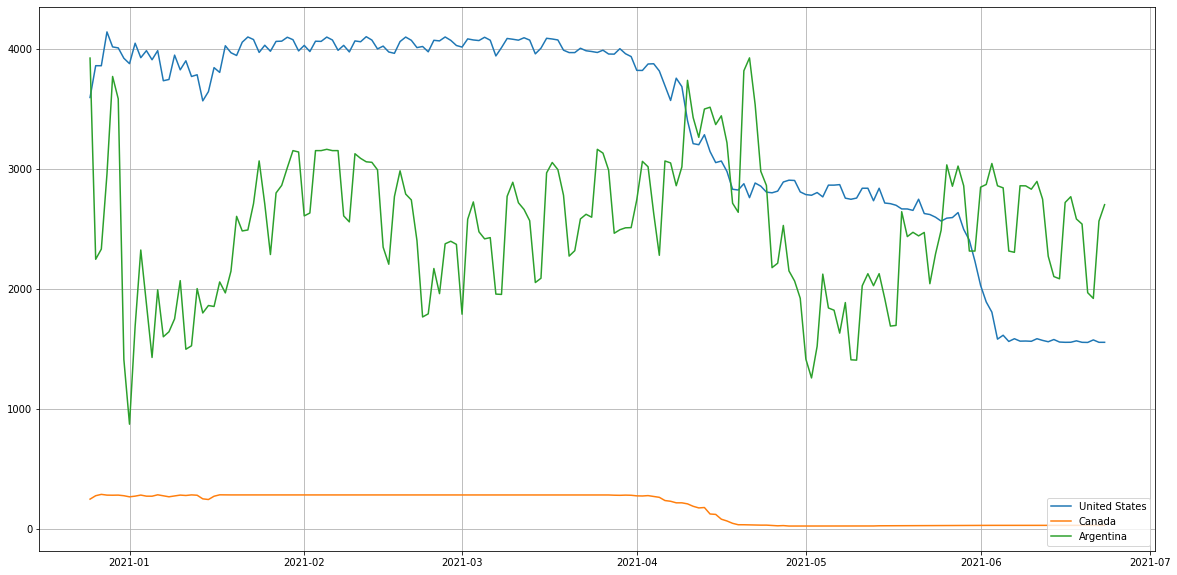

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import datetime
pf = pd.read_csv('predictions/val_6_month_future_zero.csv')
pf = pf[['CountryName','Date','PredictedDailyNewCases']]
pf = pf.groupby(['CountryName','Date']).mean()
pf = pf.reset_index()

tf = pf[pf['CountryName']=='United States']
xdates = list(tf['Date'])
xdates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in xdates]
usa = list(tf['PredictedDailyNewCases'])

tf = pf[pf['CountryName']=='Canada']
can = list(tf['PredictedDailyNewCases'])

tf = pf[pf['CountryName']=='Argentina']
arg = list(tf['PredictedDailyNewCases'])

fig = plt.figure(figsize=(20,10))
ax = plt.subplot(111)
plt.plot(xdates, usa,label='United States')
plt.plot(xdates, can,label='Canada')
plt.plot(xdates, arg,label='Argentina')
plt.legend(loc=4)
plt.grid()
plt.show()